# GPON Network visualizations - Part 3

## Today's visualization data

Now, I have made it clear that data in this series is synthetic, and that I try to generate it to look like the real sources (I'm pretty sure you can imagine why this is), yet the remarks and points we make are based on our previous experience working with this kind of data, and this is because I would like to awake your curiosity, so you can check if the data in your network behaves in a similar fashion to what I portray here. So, we will generate today's data to try and simulate a phenomena that we have seen in our network, but, with totally made up stats, and without being statistically rigorous (why? because to be statistically rigorous we would need real data to try and model), and this behavior is:

* As the quantity of total clients in a OLT increases, so does the total throughput (duh!), but, the __average speed per client (Mbps per client)__ converges to a value, and that value converges from a large quantity with less clients, to a relatively low value, as there are more clients in the OLT.

By __average speed per client (Mbps per client, Mbps for short)__ we mean just the division between the total throughput (Mbps) and the total client quantity (clients) in an OLT. Although it is a simplification of phenomena involving the throughput of a client (weather you want to look at it as an average, or as instantaneous phenomena), it allows you to get a quick and simple grasp of the behavior of your clients, regarding their bandwidth consumption.

To show this intricate relationship with synthetic data we need two variables: the total throughput of one OLT, and the total client quantity, and as before simulate the fact that in a network there can be many OLT. Let me clarify about these KPI:

* When I say "total throughput", I mean the average of the throughput over the period of a month in the Uplink interface (to the aggregation network), to be more specific, so lets say you record the highest throughput of an OLT (leaving the highest 5 % out, to leave outliers out of the measurement) every day, and you do it for the 30 days of the whole month, then you average that, that is what we will call "total throughput" per OLT per month.
* "Total client quantity", I normally record it at the end of a period, in this case, also a month (remember clients are sort of cumulative phenomenon, normally they don't vary that much).

Both the total throughput per OLT, and the total quantity of clients will be modeled by sampling from two different skewed (the skewness of a distribution is a property that roughly can be understood as how much lean in one direction does the distribution has, you can check the Wikipedia page here for more info [Skewness in Wikipedia](https://en.wikipedia.org/wiki/Skewness) normal distributions, with different parameters. So lets dive into it:

In [1]:
# Make all the imports needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm

The parameters for the client quantity variable will be:

* "a": Indicating the "skewness" of the distribution.
* "loc": Here we can safely say that it acts as an average per OLT, measured in quantity of clients.
* "scale": Also safe to say that it acts as a standard deviation of the distribution per OLT, measured in quantity of clients.
* "size": Its the quantity of points (OLTs) we want our random variable to have, measured in quantity of OLTs.

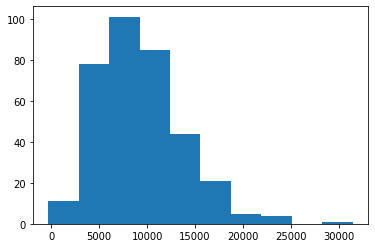

In [2]:
a = 3
loc = 4500
scale = 6500
size = 350
client_qty = skewnorm.rvs(a, loc, scale, size, random_state=28)
plt.hist(np.sort(client_qty))
plt.show()

And in the histogram of the variable we can see its tail is more heavy to the right side of the distribution.


The parameters for the total throughput variable will be:

* "a": the same as before, just this time the value is negative, as we want this variable to be skewed to the left side.
* "loc": Here we can safely say that it acts as an average per OLT, measured in Mbps.
* "scale": Also safe to say that it acts as a standard deviation of the distribution per OLT, measured in Mbps.
* "size": Its the quantity of points (OLTs) we want our random variable to have, measured in quantity of OLTs.

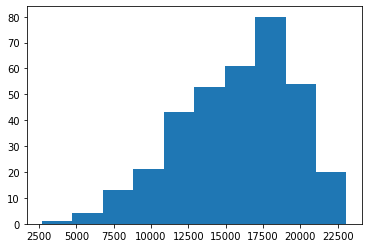

In [3]:
a = -4
loc = 20500
scale = 6000
size = 350
total_throughput = skewnorm.rvs(a, loc, scale, size, random_state=178)
plt.hist(np.sort(total_throughput))
plt.show()

Now let's create our synthetic dataset, we put it all together and have the following:

In [4]:
data_df = pd.DataFrame([np.sort(client_qty), np.sort(total_throughput)])
data_df = data_df.T
data_df.rename(columns={0:'client_qty', 1:'throughput'}, inplace=True)
data_df['avg_speed'] = data_df['throughput'].divide(data_df['client_qty'])
data_df

,client_qty,throughput,avg_speed
0,-304.960927,2703.901709,-8.866387
1,311.716539,5297.790454,16.995539
2,1414.200891,5655.028146,3.998745
3,1814.243231,5865.345508,3.232943
4,1927.319820,6298.190564,3.267849
...,...,...,...
345,22440.888053,22403.276392,0.998324
346,23301.057958,22689.817493,0.973768
347,23680.830381,22814.794197,0.963429
348,24796.414377,22995.301187,0.927364


And last but not least we then add a new column named "color", to store a tag, which will help us to make the visualization more functional (I'll explain later). In order to do this I will create a function that we're going to call __colorizer__, and then apply it to the dataframe:

In [5]:
def colorizer(x):
    """ This function assigns a color 'tag' to each 'OLT' depending on the
    average speed:
    - 'red' if avg_speed is greater than 6
    - 'blue' if avg_speed is between 2 and 6
    - 'green' if avg_speed is lower than 2 """
    
    return str(np.where((x['avg_speed']>6), 'red', np.where((x['avg_speed']>2) & (x['avg_speed']<=6), 'blue', 'green')))

data_df['colors'] = data_df.apply(colorizer, axis=1)

After that we obtain a Pandas dataframe with 350 rows, representing each individual OLT, and three columns: __client_qty,	throughput,	avg_speed, color__, which should be self explanatory.

## Create the visualization

1. Declare the figure, its axes, and some auxiliary variables, these variables will help us make the code more readable:

In [11]:
plt.rcParams.update({'font.size':15, 'figure.figsize': (20,8)})
fig, ax = plt.subplots()

avg_speed = data_df['avg_speed']
client_per_olt = data_df['client_qty']
throughput_olt = data_df['throughput']
colors = data_df['colors']

2. Declare the actual scatter plot, using the client quantity as the "x" axis values, and the average speed per client as the "y" axis. We will also code the average speed per client in the color and the size of the bubbles in the scatter plot, just to give us an additional visual sense of the values and affirm the relationship between the variables:

In [12]:
scatter = ax.scatter(x=client_per_olt, y=avg_speed, c=colors.astype('category').cat.codes*100, s=avg_speed*400, alpha=0.3, cmap='prism')

3. Then let us add an annotation with the name of the OLT with the highest value for the client speed, in this way you'll be aware which OLT it is. In this example I will __hard code__ the name of the OLT with the "hypothetical_olt" variable, but, you will have to calculate the name of the OLT with the highest client speed, you can do this by using the __.max()__ function on the mentioned column, and then put the value inside "y" axis of this the "xy" parameter:

In [13]:
lowest_t = throughput_olt.min()
hypothetical_olt = 'Highest speed per client OLT'
annotation = ax.annotate('{}'.format(hypothetical_olt), xytext=(.15,.5), xy=(800,15), xycoords='data', textcoords='axes fraction', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
ax.add_artist(annotation)

4. And finally add the legend, and finish it with some labels for the main axis. To extract the elements for the legend, we use the "legend_elements()[0]" function, this will extract the colors and figures used in the plot, so we can use it in the legend: 

In [14]:
classes = ('gt 6Mbps','2Mbps & 6Mbps', 'lt 2Mbps')
legend1 = ax.legend(handles=scatter.legend_elements()[0]*10, labels=classes, loc='upper right', title='Legend')
ax.add_artist(legend1)

ax.set_ylim(0,20)
plt.xlabel('Client quantity per OLT')
plt.ylabel('Total Thoughput per OLT (Mbps)')
plt.show()

When we put it together we get:

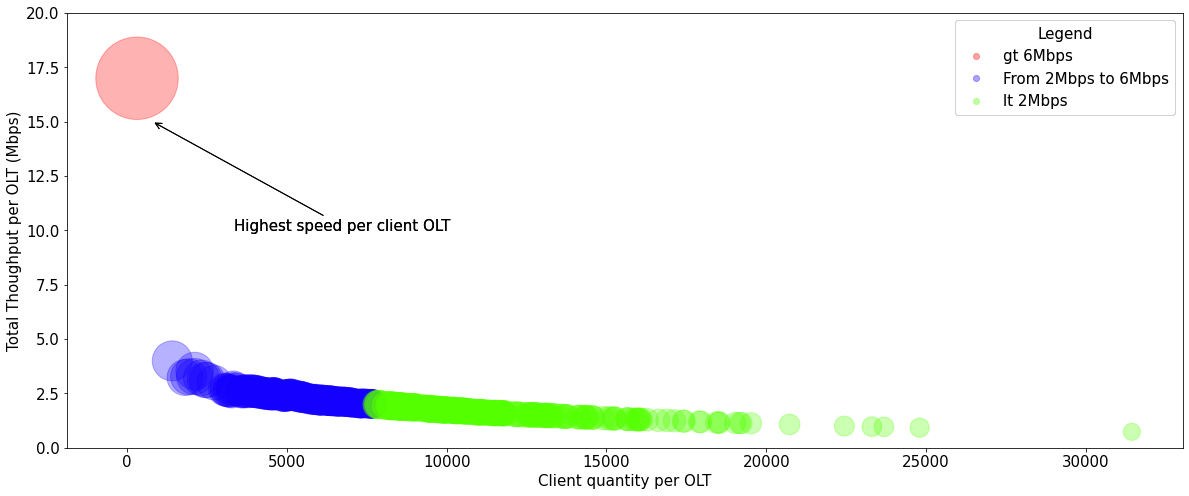

In [10]:
plt.rcParams.update({'font.size':15, 'figure.figsize': (20,8)})
fig, ax = plt.subplots()

avg_speed = data_df['avg_speed']
client_per_olt = data_df['client_qty']
throughput_olt = data_df['throughput']
colors = data_df['colors']

scatter = ax.scatter(x=client_per_olt, y=avg_speed, c=colors.astype('category').cat.codes*100, s=avg_speed*400, alpha=0.3, cmap='prism')

lowest_t = throughput_olt.min()
hypothetical_olt = 'Highest speed per client OLT'
annotation = ax.annotate('{}'.format(hypothetical_olt), xytext=(.15,.5), xy=(800,15), xycoords='data', textcoords='axes fraction', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
ax.add_artist(annotation)

classes = ('gt 6Mbps','From 2Mbps to 6Mbps', 'lt 2Mbps')
legend1 = ax.legend(handles=scatter.legend_elements()[0]*10, labels=classes, loc='upper right', title='Legend')
ax.add_artist(legend1)

ax.set_ylim(0,20)
plt.xlabel('Client quantity per OLT')
plt.ylabel('Total Thoughput per OLT (Mbps)')
plt.show()

## Closing comments

* As we expected, the OLTs with less total clients have higher average speeds per client.
    - There is one OLT with a very high average speed per client, in red color, and pointed at. In your data you could have several, and taking notice about this will help you get to know better your network.
    - The kind of behavior mentioned in the previous point is normally attributable to OLTs recently installed and that have very few users, so you don't want this kind of behavior in an old OLT with a lot of clients, that could mean there can be problems inside the PON port with privileged users, or not fair QoS parameters configured.
    - The color code we used to embed the average speed value is: red for speeds greater than 6 Mbps, blue for less or equal to 6 Mbps up to 2 Mbps, and green for speeds less than 2 Mbps.
    - As you can see, past some specific client quantity value the average client speed value converges, in our data it converges to less than 2 Mbps, but in your data it will definitely converge to a different and more interesting value.
    - This convergence value will be a very powerful KPI for you to have, because you could easily use it to extrapolate the throughput consumption of future OLTs, in future FTTx deployments.
    - Even though the KPI mentioned above is simplifying the intricate and non linear relationship of variables inside the network, it doesn't lose its power, and don't undeerstimate its usefulness in your future network planning.
* The shape of the "line" that the OLTs form conveys a lot of information too, because it represents the relationship between the client quantity, the average client speed, and as a proxy, to the throughput, although you could also make a plot with the total throughput as the y axis.

I hope this was useful for you, and that you are looking forward for the next visualization!
